Dataset of full synthetic library of 160,000 variants generated by NK model (with parameters N=4, K=1, A=20)

Preprocessed like the phoq, GB1 datasets.

In [7]:
import itertools
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gpmodel import gpmodel, gpkernel, gptools, chimera_tools

In [2]:
with open('../inputs/syn_lib_NOT_TIDY.pkl', 'rb') as f:
    t = pickle.load(f)
    
variants = np.array(t[0])
fitness = np.array(t[1])

In [3]:
def enc_to_string(encs):
    """ Takes in a numpy array of length 4 encodings given by the NK model, 
    and converts the encodings to strings of amino acids"""
    
    amino_acids = 'ARNDCQEGHILKMFPSTWYV'
    variants = []
    
    for e in encs:
        var = amino_acids[e[0]] + amino_acids[e[1]] + amino_acids[e[2]] + amino_acids[e[3]]
        variants.append(var)
        
    return np.array(variants)

vars_str = enc_to_string(variants)

In [4]:
d = {'Variants': [], 'Fitness': []}

for var, fit in zip(vars_str, fitness):
    d['Variants'].append(var)
    d['Fitness'].append(fit)
    
df = pd.DataFrame(data=d) # make dataframe of sampled ys to plot on swarmplot

In [5]:
def make_Xs(df):
    """ Make sure df has the index you want for the Xs"""
    contacts = list(itertools.combinations((0, 1, 2, 3), 2))

    amino_acids = 'ARNDCQEGHILKMFPSTWYV'

    sample_space = [amino_acids for _ in range(len(df.iloc[0]['Variants']))]
    seq_terms = chimera_tools.make_sequence_terms(sample_space)
    struct_terms = chimera_tools.contacting_terms(sample_space, contacts)
    all_terms = seq_terms + struct_terms
 
    seqs = df['Variants'].values
    struct_X, _ = chimera_tools.make_contact_X(seqs, None, contacts,
                                               contact_terms=struct_terms)
    seq_X, _ = chimera_tools.make_sequence_X(seqs, sample_space=sample_space,
                                             sequence_terms=seq_terms)
    #all_X = np.concatenate([seq_X, struct_X], axis=1)
    X_dumb = np.zeros((len(df), len(df.iloc[0]['Variants'])))
    aa = np.array(sorted(amino_acids))
    for i, seq in enumerate(seqs):
        for j, s in enumerate(seq):
            X_dumb[i, j] = np.argwhere(aa == s).flatten()

    return seq_X, X_dumb

X, T = make_Xs(df)
y = df.loc[:, 'Fitness']

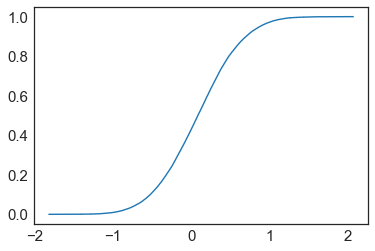

In [8]:
_ = plt.plot(np.sort(y), np.linspace(0, 1, len(y)))

In [9]:
wt_ind = np.argsort(y)[len(y) // 4 * 3]
wt_ind

51766

In [11]:
with open('../inputs/syn_lib.pkl', 'wb') as f:
    pickle.dump((X, T, y, wt_ind), f)